In [11]:
import os
import torch
from monai.inferers import SlidingWindowInferer
from PIL import Image
import numpy as np
from torchvision import transforms as T
import matplotlib.pyplot as plt
import ttach as tta
import models.my_smp as smp
import tifffile

CHECK_POINT_PATH = "exp/kelp/train_fabric/unet_segrsnet-14_bce_adamw_256x/best.pth"

# create .cache folder
DATASET = "kelp"
# Available models: segrsnet-14, segrsnet-26, segrsnet-50, segrsnet-101
VERSION = "14"  # Choose segrsnet-14

ENCODER_NAME = f"segrsnet-{VERSION}"

model = smp.Unet(
            encoder_name=ENCODER_NAME,
            classes=1,
            encoder_weights=None,
            in_channels=7
        )

state_dict = torch.load(CHECK_POINT_PATH, map_location=torch.device("cpu"))["model"]
state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict, strict=True)

FileNotFoundError: [Errno 2] No such file or directory: 'exp/kelp/train_fabric/unet_segrsnet-14_bce_adamw_256x/best.pth'

In [ ]:
# use monai to predict the fully resolution image
from datasets.kelp import KelpDataset
from tqdm import tqdm


sliding_window_inferer = SlidingWindowInferer(
    roi_size=(320) * 2, sw_batch_size=4
)

# do inference
model.eval()

now_device = torch.device("cpu")

if torch.cuda.is_available():
    now_device = torch.device("cuda")
elif torch.backends.mps.is_built():
    now_device = torch.device("mps")

print(f"Using {now_device} for inference")
model = model.to(device=now_device)

DATASET_PATH = "datasets/datasets"

test_set = KelpDataset(
            dataset_root=DATASET_PATH, ids_filepath=f'{DATASET_PATH}/need_pred_ids.txt', test_mode=True
        )

PRED_RESULTS_PATH = CHECK_POINT_PATH.replace("best.pth", "test_kelp")
if not os.path.exists(PRED_RESULTS_PATH):
    os.makedirs(PRED_RESULTS_PATH)
    
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')

for i in tqdm(range(len(test_set))):
    img, _ = test_set[i]
    img_name = os.path.basename(test_set.paths[i])
    # print(img_name)
    img = img.unsqueeze(0).to(device=now_device)
    pred = sliding_window_inferer(img, tta_model)
    pred = pred.sigmoid().squeeze(0).detach().cpu().numpy()
    pred = np.where(pred > 0.5, 1, 0).astype(np.uint8)
    pred = np.transpose(pred, (1, 2, 0))
    pred = np.squeeze(pred)
    pred = pred.astype(np.uint8)
    pred = Image.fromarray(pred)
    pred.save(os.path.join(PRED_RESULTS_PATH, img_name.replace("_satellite", "_kelp")))
    # print(f"Image {img_name} done")

Using cuda for inference


  0%|          | 0/1426 [00:00<?, ?it/s]

100%|██████████| 1426/1426 [02:14<00:00, 10.58it/s]


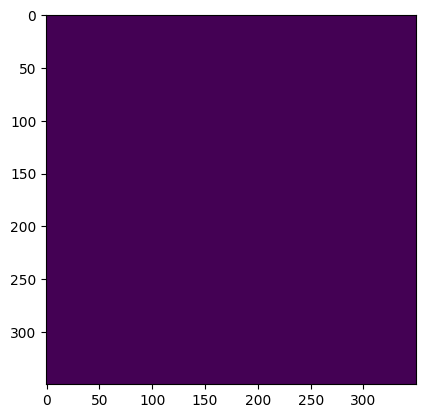

In [ ]:
plt.imshow(pred)

In [ ]:
# zip the results
import shutil
# minimum size
shutil.make_archive(PRED_RESULTS_PATH, 'zip', PRED_RESULTS_PATH)

shutil.move(f"{PRED_RESULTS_PATH}.zip", f"{CHECK_POINT_PATH.replace('best.pth', '')}/{CHECK_POINT_PATH.split('/')[-2]}.zip")

'exp/kelp/train_fabric/unet_segrsnet-14_bce_adamw_256x//unet_segrsnet-14_bce_adamw_256x.zip'